In [1]:
library(tidyverse)
library(lubridate)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.0     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:dplyr':

    intersect, setdiff, union


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [174]:
COVID_19 <- read_csv("./covid19model-1.0/data/COVID-19-up-to-date.csv") %>% 
                unite(date, year, month, day, sep = "-") %>% 
                rename(Country = countriesAndTerritories) %>% 
                mutate(date =  as.Date(date),
                       percent_cases = cases/popData2018, 
                       percent_deaths = deaths/popData2018) %>% 
                ungroup()  


Parsed with column specification:
cols(
  dateRep = col_character(),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  cases = col_double(),
  deaths = col_double(),
  countriesAndTerritories = col_character(),
  geoId = col_character(),
  countryterritoryCode = col_character(),
  popData2018 = col_double()
)



In [206]:
dim(COVID_19)
head(COVID_19)

[1] 7320   10

dateRep,date,cases,deaths,Country,geoId,countryterritoryCode,popData2018,percent_cases,percent_deaths
<chr>,<date>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
28/03/2020,2020-03-28,16,1,Afghanistan,AF,AFG,37172386,4.304270e-07,2.690169e-08
27/03/2020,2020-03-27,0,0,Afghanistan,AF,AFG,37172386,0.000000e+00,0.000000e+00
26/03/2020,2020-03-26,33,0,Afghanistan,AF,AFG,37172386,8.877558e-07,0.000000e+00
25/03/2020,2020-03-25,2,0,Afghanistan,AF,AFG,37172386,5.380338e-08,0.000000e+00
24/03/2020,2020-03-24,6,1,Afghanistan,AF,AFG,37172386,1.614101e-07,2.690169e-08
23/03/2020,2020-03-23,10,0,Afghanistan,AF,AFG,37172386,2.690169e-07,0.000000e+00


In [160]:
interventions  <- read_csv("./covid19model-1.0/data/interventions.csv")  %>% 
                    select(-contains("X")) %>% 
                    mutate(travel_restrictions = as.character(travel_restrictions))

Warning message:
"Missing column names filled in: 'X9' [9], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21]"
Parsed with column specification:
cols(
  .default = col_character(),
  travel_restrictions = col_date(format = ""),
  X9 = col_logical(),
  X14 = col_logical(),
  X15 = col_logical(),
  X16 = col_logical(),
  X17 = col_logical(),
  X18 = col_logical(),
  X19 = col_logical(),
  X20 = col_logical(),
  X21 = col_logical()
)

See spec(...) for full column specifications.



In [63]:
dim(interventions)

[1] 78 13

In [14]:
names(interventions)

[1] "Country"                                                                                                                        
 [2] "schools_universities"                                                                                                           
 [3] "travel_restrictions"                                                                                                            
 [4] "public_events"                                                                                                                  
 [5] "sport"                                                                                                                          
 [6] "lockdown"                                                                                                                       
 [7] "social_distancing_encouraged"                                                                                                   
 [8] "self_isolating_if_ill"                                                                                                          
 [9] "Data inputted by"                                                                                                               
[10] "note: enter the date on which the closing occurred, e.g. as the last day of UK schools will be 2020-03-20, I entered 2020-03-21"
[11] "comments"                                                                                                                       
[12] "Enter your github username below"                                                                                               
[13] "startdate"

In [147]:
interventions %>% 
            filter(Country == "Italy")

Country,schools_universities,travel_restrictions,public_events,sport,lockdown,social_distancing_encouraged,self_isolating_if_ill,Data inputted by,"note: enter the date on which the closing occurred, e.g. as the last day of UK schools will be 2020-03-20, I entered 2020-03-21",comments,Enter your github username below,startdate
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Italy,2020-03-05,2020-03-09,2020-03-09,2020-03-09,2020-03-11,2020-03-09,2020-03-09,Harrison,NA,NA,NA,2020-03-14
Italy,Lockdown of Lombardy region and 14 other provinces,NA,2020-03-08,26%,NA,NA,NA,NA,NA,NA,NA,2020-03-13
Italy,self-isolate if ill and quarantine if tested positive,NA,2020-03-08,extended to whole country on 9/03,NA,NA,NA,NA,NA,NA,NA,2020-03-13
Italy,Extended lockdown (non-essential shops + restaurants + caffee still open),NA,2020-03-09,NA,NA,NA,NA,NA,NA,NA,NA,2020-03-12
Italy,Extended lockdown + closure of non-essential shops,NA,2020-03-11,NA,NA,NA,NA,NA,NA,NA,NA,2020-03-14
Italy,Extended lockdown + further closure of non-essential businesses and activities,NA,2020-03-22,NA,NA,NA,NA,NA,NA,NA,NA,2020-03-16
Italy,4.994.995,NA,5.733.448,6.998.434,9.022.004,9.567.192,7.484.862,6.028.908,4.528.549,54.358.392,NA,21/03/2020


In [65]:
germany <- c("NRW","Bayern", "BW", "Niedersachsen", "Hessen", "RP", "Sachsen",
             "Berlin", "SH", "Brandenburg", "Sachsen A", "Thueringen", "Hamburg", 
             "MeckPom", "Saarland", "Bremen 683")
extra_info <- c("Country","Partial lockdowns")

restriction_dates <- interventions %>% 
                        select(1:8) %>%  
                        pivot_longer(cols = 2:8, 
                                     names_to = "restriction_type", 
                                     values_to = "restriction_date") %>%
                        filter(!is.na(Country), 
                               !(Country %in% c(extra_info, germany))) %>% 
                        filter(grepl(pattern = "2020-", x = restriction_date)) %>% 
                        mutate(restriction_date = as.Date(restriction_date))

In [146]:
dim(restriction_dates)
restriction_dates %>% filter(Country == "Italy")

[1] 104   3

Country,restriction_type,restriction_date
<chr>,<chr>,<date>
Italy,schools_universities,2020-03-05
Italy,travel_restrictions,2020-03-09
Italy,public_events,2020-03-09
Italy,sport,2020-03-09
Italy,lockdown,2020-03-11
Italy,social_distancing_encouraged,2020-03-09
Italy,self_isolating_if_ill,2020-03-09
Italy,public_events,2020-03-08
Italy,public_events,2020-03-08


In [72]:
restriction_dates %>% 
        filter(restriction_type == "lockdown") %>% 
        arrange(restriction_date)                                                 

Country,restriction_type,restriction_date
<chr>,<chr>,<date>
Italy,lockdown,2020-03-11
Spain,lockdown,2020-03-14
Austria,lockdown,2020-03-16
France,lockdown,2020-03-17
Belgium,lockdown,2020-03-18
Denmark,lockdown,2020-03-18
Switzerland,lockdown,2020-03-20
Germany,lockdown,2020-03-22
Norway,lockdown,2020-03-24


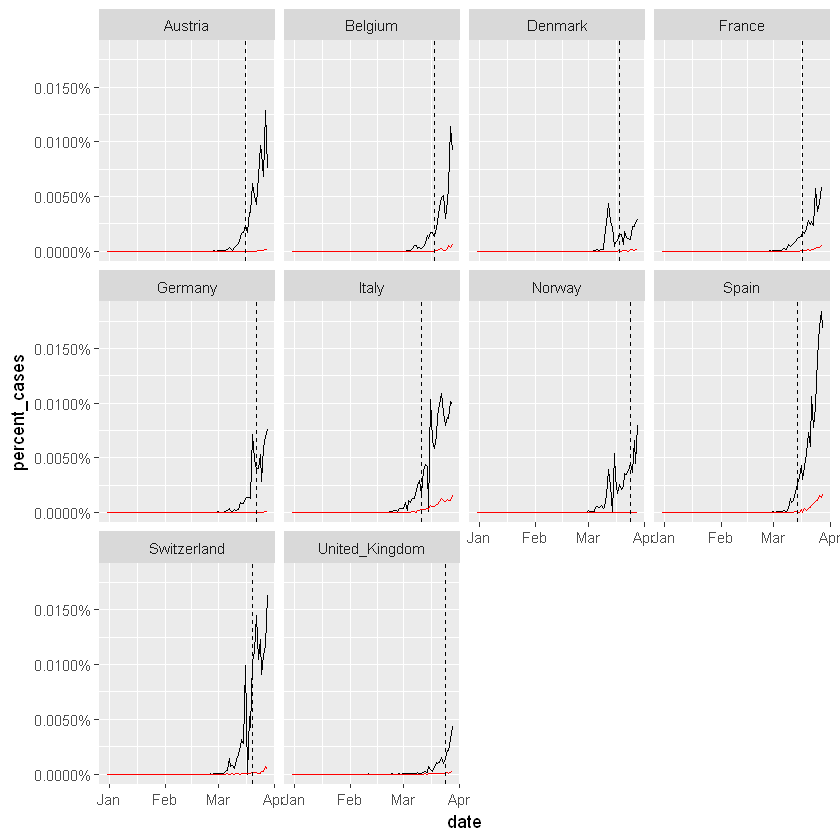

In [126]:
lockdown_dates <- restriction_dates %>% 
        filter(restriction_type == "lockdown")

COVID_19 %>% 
    inner_join(restriction_dates %>% filter(restriction_type == "lockdown"), 
               by = "Country") %>%
    ggplot() +
        geom_line(aes(date, percent_cases)) +
        geom_line(aes(date, percent_deaths), color = "red") +
        geom_vline(aes(xintercept = restriction_date), lty = 2) +
        facet_wrap(~Country) +
        scale_y_continuous(labels = scales::percent_format())

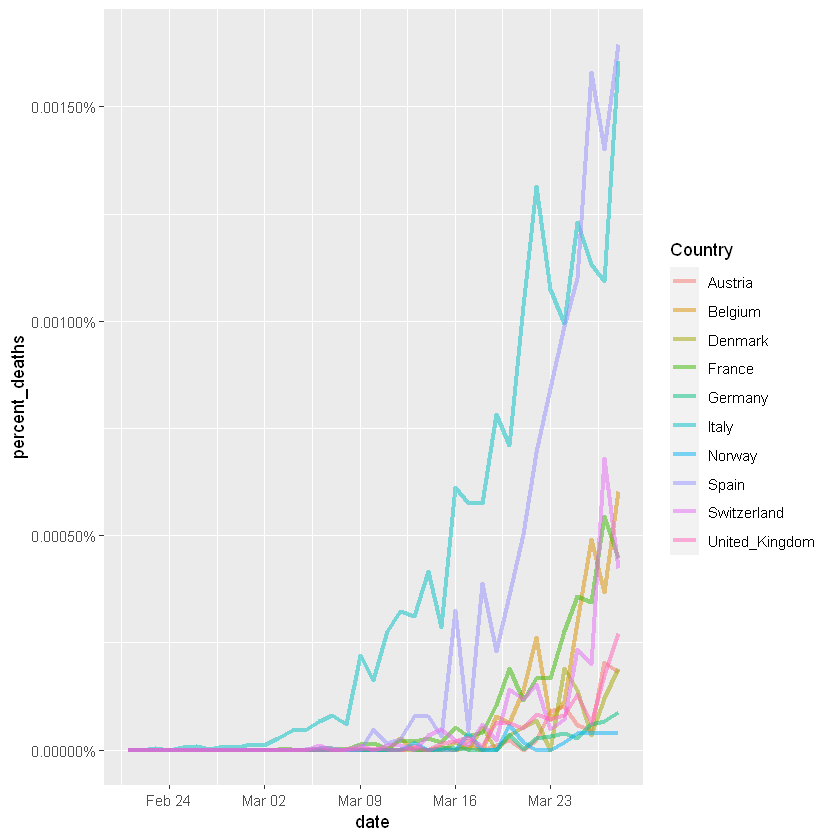

In [254]:
COVID_19 %>% 
    inner_join(restriction_dates %>% filter(restriction_type == "lockdown"), 
               by = "Country") %>%
    filter(date > as.Date("2020-02-20")) %>% 
    ggplot() +
        geom_line(aes(date, percent_deaths, color = Country), size = 1.2, alpha = 0.5) +
        scale_y_continuous(labels = scales::percent_format())

### Cummulative Cases and Deaths

In [218]:
COVID_cum <- restriction_dates %>%
    inner_join(COVID_19, by = c("Country", restriction_date = "date")) %>% 
    select(Country, 
           restriction_date, 
           restriction_type, 
           new_cases = cases, 
           new_deaths = deaths) %>% 
    complete(Country, restriction_date) %>% 
    mutate(new_cases = ifelse(is.na(new_cases), 0, new_cases), 
           new_deaths = ifelse(is.na(new_deaths), 0, new_deaths)) %>% 
    group_by(Country) %>% 
    mutate(cases = cumsum(new_cases), 
           deaths = cumsum(new_deaths)) %>% 
    ungroup() %>% 
    filter(!is.na(restriction_type))

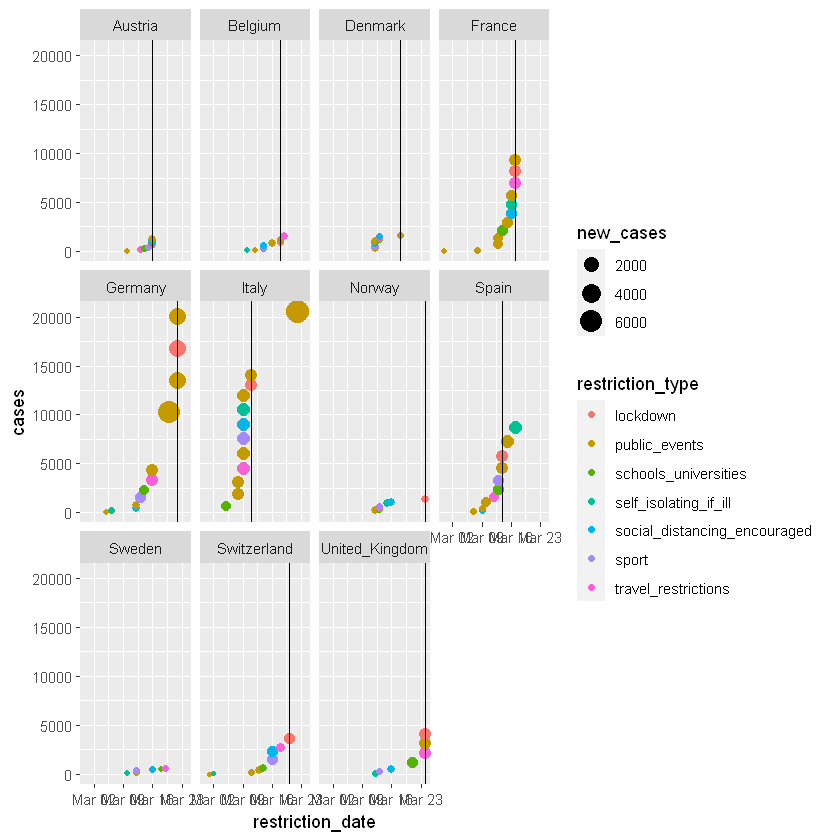

In [265]:
COVID_cum %>%
    filter(restriction_date > as.Date("2020-02-20")) %>% 
    ggplot(aes(x = restriction_date, 
               y = cases, 
               color = restriction_type, 
               size = new_cases)) +
        geom_point() +
        geom_vline(aes(xintercept = restriction_date), 
                   data = restriction_dates %>% 
                               filter(restriction_type == "lockdown")) +
        facet_wrap(~Country)